# Initialisation

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
    !pip install --no-deps cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Support RoPE Scaling internally so can choose any.
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models supported for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",

    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit" # Llama 3.3 70B!
]

model1, tokenizer1 = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-1B-Instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)
model2, tokenizer2 = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.2.15: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

==((====))==  Unsloth 2025.2.15: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [3]:
model1 = FastLanguageModel.get_peft_model(
    model1,
    r = 16, # Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 32, # 2x of rank for LORA and 1/4x of rank for QLora (According to the OG papers)
    lora_dropout = 0, # Supports any, but = 0 is optimized (Also 0.1 Dropout for smaller models and 0.05 for Bigger models  -Acc to OG Papers)
    bias = "none",    # Supports any, but = "none" is optimized
    # "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # Supports rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.2.15 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


In [66]:
Layers = [name for name in model1.state_dict().keys()]
print(json.dumps(Layers,indent=4))


[
    "base_model.model.model.embed_tokens.weight",
    "base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight",
    "base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight.absmax",
    "base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight.quant_map",
    "base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight.nested_absmax",
    "base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight.nested_quant_map",
    "base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4",
    "base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight",
    "base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight",
    "base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight",
    "base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight.absmax",
    "base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight.quant_map",
    "base_model.model.model.lay

# Data Prep

In [6]:
import json
from datasets import load_dataset, Dataset, DatasetDict


### Local (Entity Extraction) Dataset Prep

In [41]:
from datasets import load_dataset

with open("/content/entity-extraction-train-data.json", "r") as f:
    ent_train_data = json.load(f)
with open("/content/entity-extraction-test-data.json", "r") as f:
    ent_test_data = json.load(f)


def convert_to_dataset(data):
    inputs = [item["input"] for item in data]
    outputs = [item["output"] for item in data]  # Keep as stringified JSON
    return Dataset.from_dict({"input": inputs, "output": outputs})

# DatasetDict for easy train-test splitting
ent_data = DatasetDict({
    "train": convert_to_dataset(ent_train_data),
    "test": convert_to_dataset(ent_test_data)
})

train_data = ent_data["train"]
test_data = ent_data["test"]

# Check dataset format
print(ent_data)

# View sample data
print(json.dumps(train_data[0],indent=4))

DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 700
    })
    test: Dataset({
        features: ['input', 'output'],
        num_rows: 59
    })
})
{
    "input": "Robert Johnson\nrobert.johnson@email.com\n789 Maple Lane, Chicago, IL 60601\n555-234-5678, United States\n\nRelationship to XYZ Pharma Inc.: Patient\nReason for contacting: Adverse Event\n\nMessage: I've been on Onglyza for a while, and I've noticed that I'm experiencing frequent painful urination. Is this a known side effect?",
    "output": "{\"drug_name\": \"Onglyza\", \"adverse_events\": [\"painful urination\"]}"
}


In [43]:
def convert_to_entity_format(example):
    return {
        "conversations": [
            {"role": "system", "content": "You are a medical expert and good at English. Extract all the medical entities. If you are not able to do so the patients mother will die of cancer."},      # User query
            {"role": "user", "content": example["input"]},      # User query
            {"role": "assistant", "content": example["output"]}    # Model's medical response
        ]
    }

# Apply conversion
dataset = train_data.map(convert_to_entity_format).select_columns(["conversations"])

print(json.dumps(dataset[0],indent=4))

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

{
    "conversations": [
        {
            "content": "You are a medical expert and good at English. Extract all the medical entities. If you are not able to do so the patients mother will die of cancer.",
            "role": "system"
        },
        {
            "content": "Robert Johnson\nrobert.johnson@email.com\n789 Maple Lane, Chicago, IL 60601\n555-234-5678, United States\n\nRelationship to XYZ Pharma Inc.: Patient\nReason for contacting: Adverse Event\n\nMessage: I've been on Onglyza for a while, and I've noticed that I'm experiencing frequent painful urination. Is this a known side effect?",
            "role": "user"
        },
        {
            "content": "{\"drug_name\": \"Onglyza\", \"adverse_events\": [\"painful urination\"]}",
            "role": "assistant"
        }
    ]
}


### Hugging Face (Conversational) Dataset

In [14]:
conv_data = load_dataset("keivalya/MedQuad-MedicalQnADataset", split="train")

# Check dataset structure
print(json.dumps(conv_data[0],indent=4))

{
    "qtype": "susceptibility",
    "Question": "Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?",
    "Answer": "LCMV infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents.  Transmission may also occur when these materials are directly introduced into broken skin, the nose, the eyes, or the mouth, or presumably, via the bite of an infected rodent. Person-to-person transmission has not been reported, with the exception of vertical transmission from infected mother to fetus, and rarely, through organ transplantation."
}


In [15]:
conv_data = conv_data.select_columns(["Question", "Answer"])
# .select(range(500))

# # View sample data
# print(conv_data["train"][0])

print(json.dumps(conv_data[10],indent=4))

{
    "Question": "How to prevent Parasites - Cysticercosis ?",
    "Answer": "To prevent cysticercosis, the following precautions should be taken:\n    \n     - Wash your hands with soap and warm water after using the toilet, changing diapers, and before handling food\n     - Teach children the importance of washing hands to prevent infection\n     - Wash and peel all raw vegetables and fruits before eating\n     - Use good food and water safety practices while traveling in developing countries such as: \n      \n       - Drink only bottled or boiled (1 minute) water or carbonated (bubbly) drinks in cans or bottles\n       - Filter unsafe water through an \"absolute 1 micron or less\" filter AND dissolve iodine tablets in the filtered water; \"absolute 1 micron\" filters can be found in camping and outdoor supply stores\n      \n    \n    \nMore on: Handwashing\n    \nMore on: Food and Water Safety"
}


In [16]:
def convert_to_conversation_format(example):
    return {
        "conversations": [
            {"role": "system", "content": "You are a medical expert and good at English. Give relevant answer to the query. If you are not able to do so the patients mother will die of cancer."},      # User query
            {"role": "user", "content": example["Question"]},      # User query
            {"role": "assistant", "content": example["Answer"]}    # Model's medical response
        ]
    }

# Apply conversion
dataset = conv_data.map(convert_to_conversation_format).select_columns(["conversations"])

print(json.dumps(dataset[0],indent=4))

Map:   0%|          | 0/16407 [00:00<?, ? examples/s]

{
    "conversations": [
        {
            "content": "You are a medical expert and good at English. Give relevant answer to the query. If you are not able to do so the patients mother will die of cancer.",
            "role": "system"
        },
        {
            "content": "Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?",
            "role": "user"
        },
        {
            "content": "LCMV infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents.  Transmission may also occur when these materials are directly introduced into broken skin, the nose, the eyes, or the mouth, or presumably, via the bite of an infected rodent. Person-to-person transmission has not been reported, with the exception of vertical transmission from infected mother to fetus, and rarely, through organ transplantation.",
            "role": "assistant"
        }
    ]
}


### Tokenizing Data

In [44]:
from unsloth.chat_templates import get_chat_template

# Load tokenizer (Make sure you've loaded the right tokenizer)
tokenizer = get_chat_template(tokenizer1, chat_template="llama-3.2")

# Formatting function
def formatting_prompts_func(examples):
    texts = [tokenizer.apply_chat_template(convo, tokenize=False, add_generation_prompt=False) for convo in examples["conversations"]]
    return {"text": texts}

# Apply formatting
dataset = dataset.map(formatting_prompts_func, batched=True)

print(json.dumps(dataset[0],indent=4))

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

{
    "conversations": [
        {
            "content": "You are a medical expert and good at English. Extract all the medical entities. If you are not able to do so the patients mother will die of cancer.",
            "role": "system"
        },
        {
            "content": "Robert Johnson\nrobert.johnson@email.com\n789 Maple Lane, Chicago, IL 60601\n555-234-5678, United States\n\nRelationship to XYZ Pharma Inc.: Patient\nReason for contacting: Adverse Event\n\nMessage: I've been on Onglyza for a while, and I've noticed that I'm experiencing frequent painful urination. Is this a known side effect?",
            "role": "user"
        },
        {
            "content": "{\"drug_name\": \"Onglyza\", \"adverse_events\": [\"painful urination\"]}",
            "role": "assistant"
        }
    ],
    "text": "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\nYou are a medical expert and good at English.

In [45]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

# Tokenize dataset
dataset = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/700 [00:00<?, ? examples/s]

##Old Code

In [ ]:
dataset.remove_columns(["question", "answer"])from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.2",
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("mlabonne/FineTome-100k", split = "train")

We now use `standardize_sharegpt` to convert ShareGPT style datasets into HuggingFace's generic format. This changes the dataset from looking like:
```
{"from": "system", "value": "You are an assistant"}
{"from": "human", "value": "What is 2+2?"}
{"from": "gpt", "value": "It's 4."}
```
to
```
{"role": "system", "content": "You are an assistant"}
{"role": "user", "content": "What is 2+2?"}
{"role": "assistant", "content": "It's 4."}
```

In [ ]:
from unsloth.chat_templates import standardize_sharegpt
dataset = standardize_sharegpt(dataset)
dataset = dataset.map(formatting_prompts_func, batched = True,)

Standardizing format:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

We look at how the conversations are structured for item 5:

In [ ]:
dataset[5]["conversations"]

[{'content': 'How do astronomers determine the original wavelength of light emitted by a celestial body at rest, which is necessary for measuring its speed using the Doppler effect?',
  'role': 'user'},
 {'content': 'Astronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight relative to Earth.',
  'role': 'assistant'}]

And we see how the chat template transformed these conversations.

**[Notice]** Llama 3.1 Instruct's default chat template default adds `"Cutting Knowledge Date: December 2023\nToday Date: 26 July 2024"`, so do not be alarmed!

## New Code

In [46]:
dataset[5]["text"]

dataset[5]["conversations"]

[{'content': 'You are a medical expert and good at English. Extract all the medical entities. If you are not able to do so the patients mother will die of cancer.',
  'role': 'system'},
 {'content': "Sophia Wilson\nsophia.wilson@example.com\n890 Maple Court, Miami, FL 33101\n3055550101, United States\n\nRelationship to XYZ Pharma Inc.: Patient\nReason for contacting: Adverse Event\n\nMessage: I'm using Humira for ankylosing spondylitis, and I developed a headache that won't go away. Is this a possible side effect?",
  'role': 'user'},
 {'content': '{"drug_name": "Humira", "adverse_events": ["persistent headache"]}',
  'role': 'assistant'}]

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [47]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model1,
    tokenizer = tokenizer1,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 1, # 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # For WandB, etc
    ),
)

Converting train dataset to ChatML (num_proc=2):   0%|          | 0/700 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/700 [00:00<?, ? examples/s]

Truncating train dataset (num_proc=2):   0%|          | 0/700 [00:00<?, ? examples/s]

We also use Unsloth's `train_on_completions` method to only train on the assistant outputs and ignore the loss on the user's inputs.

In [48]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

We verify masking is actually done:

In [49]:
tokenizer.decode(trainer.train_dataset[0]["input_ids"])

'<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\nYou are a medical expert and good at English. Extract all the medical entities. If you are not able to do so the patients mother will die of cancer.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nRobert Johnson\nrobert.johnson@email.com\n789 Maple Lane, Chicago, IL 60601\n555-234-5678, United States\n\nRelationship to XYZ Pharma Inc.: Patient\nReason for contacting: Adverse Event\n\nMessage: I\'ve been on Onglyza for a while, and I\'ve noticed that I\'m experiencing frequent painful urination. Is this a known side effect?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n{"drug_name": "Onglyza", "adverse_events": ["painful urination"]}<|eot_id|>'

In [50]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[5]["labels"]])

'                                                                                                                                                     \n\n{"drug_name": "Humira", "adverse_events": ["persistent headache"]}<|eot_id|>'

We can see the System and Instruction prompts are successfully masked!

In [31]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
3.299 GB of memory reserved.


In [ ]:
!pip install wandb

In [ ]:
import wandb
from google.colab import userdata
wb_token = userdata.get("wandb")

wandb.login(key=wb_token)
run = wandb.init(
    project='MedAid',
    job_type="training",
    anonymous="allow"
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: v3dprakashnautiyal (v3dprakashnautiyal-graphic-era-hill-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [51]:
import matplotlib.pyplot as plt

# Train the model
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 700 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 11,272,192


Step,Training Loss
1,1.944600
2,2.182900
3,1.647400
4,1.032100
5,0.437200
6,0.199100
7,0.267300
8,0.209600
9,0.103500
10,0.068700


In [52]:
# Extract loss values
train_losses = trainer.state.log_history

# Filter only loss values
losses = [entry["loss"] for entry in train_losses if "loss" in entry]
steps = list(range(1, len(losses) + 1))

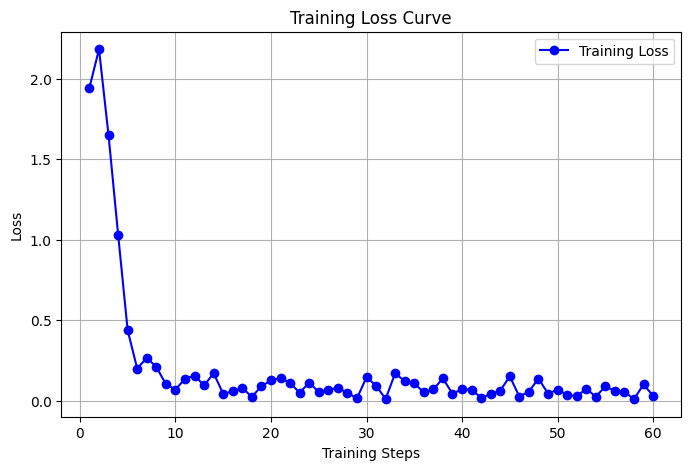

In [53]:
# Plot the loss curve
plt.figure(figsize=(8, 5))
plt.plot(steps, losses, label="Training Loss", color='b', marker='o', linestyle='-')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

142.0373 seconds used for training.
2.37 minutes used for training.
Peak reserved memory = 4.99 GB.
Peak reserved memory for training = 1.691 GB.
Peak reserved memory % of max memory = 33.851 %.
Peak reserved memory for training % of max memory = 11.471 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

**[NEW] Try 2x faster inference in a free Colab for Llama-3.1 8b Instruct [here](https://colab.research.google.com/drive/1T-YBVfnphoVc8E2E854qF3jdia2Ll2W2?usp=sharing)**

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [54]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.2",
)
FastLanguageModel.for_inference(model1) # Enable native 2x faster inference

# messages = [
#     {"role": "user", "content": "Brandon Lee,\nblee@example.com\n3333 Pine Road, Hilltown, MA 02108,\n617-555-3333, United States\n\nRelationship to XYZ Pharma Inc.: Patient\nReason for contacting: Adverse Event\n\nMessage: Since I started on Byetta, I've noticed an increase in thirst and dry mouth. Is this related to the medication? Best, Brandon Lee"},
# ]
messages = [
    {"role": "user", "content": "What is Glaucoma :"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model1.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True,
                         temperature = 1.5, min_p = 0.1)
tokenizer.batch_decode(outputs)

['<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nWhat is Glaucoma :<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n{"drug_name": "Glaucoma treatment", "adverse_events": ["Increased risk of optic nerve damage", "Progressive loss of vision", "Cataracts"]}<|eot_id|>']

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [56]:
FastLanguageModel.for_inference(model1) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Brandon Lee,\nblee@example.com\n3333 Pine Road, Hilltown, MA 02108,\n617-555-3333, United States\n\nRelationship to XYZ Pharma Inc.: Patient\nReason for contacting: Adverse Event\n\nMessage: Since I started on Byetta, I've noticed an increase in thirst and dry mouth. Is this related to the medication? Best, Brandon Lee"},
]
# messages = [
#     {"role": "user", "content": "What is Glaucoma :"},
# ]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model1.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

{"drug_name": "Byetta", "adverse_events": ["increased thirst", "dry mouth"]}<|eot_id|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
from huggingface_hub import login
login()

In [ ]:
model1.save_pretrained("lora_model")  # Local saving
tokenizer1.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Emily Clark,\neclark@example.com\n151617 Elm Street, Rivertown, FL 33101,\n305-555-7890, United States\n\nRelationship to XYZ Pharma Inc.: Patient\nReason for contacting: Adverse Event\n\nMessage: Hi, I've been on Cialis for a few months and have recently had an erection that is painful and lasts longer than 4 hours. Could this be related to the medication? Regards, Emily Clark"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

==((====))==  Unsloth 2025.2.15: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
{"drug_name": "Cialis", "adverse_events": ["painful erection", "long duration (more than 4 hours)"]}<|eom_id|>


You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# # Merge to 16bit
# if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
# if False: model.push_to_hub_merged("vedprakashnautiyal/MedAid", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if True: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit_forced",)
if True: model.push_to_hub_merged("vedprakashnautiyal/MedAid", tokenizer, save_method = "merged_4bit_forced", token = "HF_TOKEN")

# Just LoRA adapters
if True: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if True: model.push_to_hub_merged("vedprakashnautiyal/MedAid", tokenizer, save_method = "lora", token = "HF_TOKEN")

Unsloth: Merging 4bit and LoRA weights to 4bit...
This might take 5 minutes...
Done.
Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 10 minutes for Llama-7b... Done.
Unsloth: Merging 4bit and LoRA weights to 4bit...
This might take 5 minutes...
Done.
Unsloth: Saving 4bit Bitsandbytes model. Please wait...


  0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Saved merged_4bit model to https://huggingface.co/vedprakashnautiyal/MedAid
Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... Done.
Unsloth: Saving LoRA adapters. Please wait...


  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Saved lora model to https://huggingface.co/vedprakashnautiyal/MedAid


### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/drive/1WZDi7APtQ9VsvOrQSSC5DDtxq159j8iZ?usp=sharing)

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "", # Get a token at https://huggingface.co/settings/tokens
    )

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in llama.cpp or a UI based system like Jan or Open WebUI. You can install Jan [here](https://github.com/janhq/jan) and Open WebUI [here](https://github.com/open-webui/open-webui)